In [1]:
from cvxpy import Parameter, Variable, Problem, Minimize, Maximize
import cvxpy as cp
from time import time
import numpy as np
from scipy import signal

def e(i):
    return signal.unit_impulse(3,i) # create a specific basis vector

g0    = 9.80665         # standard gravity [m/s**2]
m_dry = 1505            # dry mass kg
m_fuel= 400             # fuel in kg
T_max = 3100 * 6 * np.cos(np.radians(27))           # thrust max
throt = [0.3,0.8]       # throttle ability
Isp   = 225             # fuel efficiency (specific impulse)
V_max = 90              # velocity max
y_gs  = np.radians(4)# glide slope cone, must be 0 < Degrees < 90
p_cs  = np.radians(45)  # thrust pointing constraint
alpha = 1/(Isp*g0)      # fuel consumption parameter
m_wet = (m_dry+m_fuel)  # wet mass kg
r1    = throt[0]*T_max  # lower thrust bound
r2    = throt[1]*T_max  # upper thrust bound

g = np.array([-3.7114,0,0])                   # gravity
nh= np.array([1,0,0])                     # thrust vector reference direction

r0 = np.array([1500, 0, 2000])              # initial position
v0 = np.array([-75,  0,   100])                 # initial velocity

rf = np.array([0,0,0])                      # final position target
vf = np.array([0,0,0])                      # final velocity target

c = np.divide(e(0),np.tan(y_gs))

In [4]:
def GFOLD(inputs): # PRIMARY GFOLD SOLVER

    #dt = 0.24 #1e0 # dynamics precision ----> BEWARE OF MEMORY OVERFLOW!

    if inputs[0] == 3:
        program, N, dt = inputs

    elif inputs[0]==4:
        program, N, dt, rf_ = inputs

    x0=Parameter()
    x0=np.array([r0[0],r0[1],r0[2],v0[0],v0[1],v0[2]])

    x =Variable((6,N)) # state vector (3position,3velocity)
    u =Variable((3,N)) # u = Tc/mass because Tc[:,n]/m[n] is not allowed by DCP
    z= Variable(N)  # z = ln(mass)
    s= Variable(N) # thrust slack parameter

    con = []  # CONSTRAINTS LIST

    con += [x[0:3:1,0]  == x0[0:3:1]]
    con += [x[3:6,0]  == x0[3:6]]
    con += [x[3:6,N-1]== vf] # don't forget to slow down, buddy!


    con += [z[0] == np.log(m_wet)] # convexified (7)
    #con += [z[N-1] >= np.log(m_dry)] 

    if program==3:
        con += [x[0,N-1] == 0]

    elif program==4:
        con += [x[0:3,N-1] == rf_] # force landing point equal to found p1 pt

    for n in range(0,N): # any t in [0,tf] maps to any n in [0,N-1]
        if n < N - 1:
            # Leapfrog Integration Method
            #    accurate +/- sqrt( (dt*df/dr)**2 + 1)
            #    https://goo.gl/jssWkB
            #    https://en.wikipedia.org/wiki/Leapfrog_integration

            # Dynamics --> v = A(w)*x + B*(g + u)

            con += [x[3:6,n+1] == x[3:6,n] + (dt/2)*((u[:,n]+g) + (u[:,n+1]+g))]
            con += [x[0:3,n+1] == x[0:3,n] + (dt/2)*(x[3:6,n+1]+x[3:6,n]) + dt**2/12 * (u[:,n+1] - u[:,n]) ]

            con += [z[n+1] == z[n] - (alpha*dt/2)*(s[n] + s[n+1])] # mass decreases

        con += [cp.norm(u[:,n]) <= s[n]] # limit thrust magnitude & also therefore, mass

        if n > 0:
            z0_term = m_wet - alpha * r2 * (n) * dt  # see ref [2], eq 34,35,36
            z1_term = m_wet - alpha * r1 * (n) * dt
            z0 = np.log( z0_term )
            z1 = np.log( z1_term )
            mu_1 = r1 * np.exp(-z0)
            mu_2 = r2 * np.exp(-z0)

            con += [s[n] >= mu_1 * (1 - (z[n] - z0) + (z[n] - z0)**2 / 2)] # lower thrust bound
            con += [s[n] <= mu_2 * (1 - (z[n] - z0))] # upper thrust bound
            con += [z[n] >= z0] # Ensures physical bounds on z are never violated
            con += [z[n] <= z1]

            con += [ cp.norm( (x[0:3, n] - rf)[0:2] ) - (x[2,n] - rf[2]) / np.tan(y_gs) <= 0 ] # specific, but faster


    con += [x[0, :] >= 0] # no, this is not the Boring Company!

    if program == 3:
        print('-----------------------------')
        objective=Minimize(cp.norm(x[1:3,N-1]-rf[1:]))
        problem=Problem(objective,con)
        obj_opt=problem.solve()#solver=SCS,max_iters=5000,verbose=True,use_indirect=False)
        print("status:", problem.status)
        print("cost:", problem.value)
        print('-----------------------------')
    elif program == 4:
        print('-----------------------------')
        objective=Maximize(z[N-1])
        problem=Problem(objective,con)
        obj_opt=problem.solve()#solver=SCS,max_iters=5000,verbose=True,use_indirect=False,warm_start=True) # OK to warm start b/c p1 gave us a decent answer probably
        print("status:", problem.status)
        print("cost:", problem.value)
        print('-----------------------------')

    if program == 3:
        #return obj_opt,(N/dt),x[0:3,N-1]
        if z.value is not None:
            m     = np.exp(z.value)
            return obj_opt,x,u,m,(N/dt),s,z # N/dt is tf
        else:
            return obj_opt,None,None,None,(N/dt),None,None #
    elif program == 4:
        if z.value is not None:
            m     = np.exp(z.value)
            return obj_opt,x,u,m,(N/dt),s,z # N/dt is tf
        else:
            return obj_opt,None,None,None,None,(N/dt),None,None

In [8]:
tf = 81
#for tf in range(50, 90):
dt = 1
N = int(tf / dt) + 1
obj_opt ,x,u, m, _, s, z = GFOLD((3, N, dt))

-----------------------------
status: optimal
cost: 4.670713526872165e-12
-----------------------------


In [6]:
invphi = (np.sqrt(5) - 1) / 2  # 1 / phi
invphi2 = (3 - np.sqrt(5)) / 2  # 1 / phi^2


def gss(f, a, b, tol=1e-5):
    (a, b) = (min(a, b), max(a, b))
    h = b - a
    if h <= tol:
        return (a, b)

    # Required steps to achieve tolerance
    n = int(np.ceil(np.log(tol / h) / np.log(invphi)))

    c = a + invphi2 * h
    d = a + invphi * h
    yc = f(c)
    yd = f(d)

    for k in range(n-1):
        if yc < yd:
            b = d
            d = c
            yd = yc
            h = invphi * h
            c = a + invphi2 * h
            yc = f(c)
        else:
            a = c
            c = d
            yc = yd
            h = invphi * h
            d = a + invphi * h
            yd = f(d)

    if yc < yd:
        return (a, d)
    else:
        return (c, b)

In [7]:
def problem3_seach(t_f):
    obj_opt, x, u, m, tf, s, z = GFOLD((3, int(t_f / dt) + 1, dt))
    return obj_opt

t_min = (m_wet - m_fuel) * np.linalg.norm(v0) / r2
t_max = m_fuel / (alpha * r1)

lower, upper = gss(problem3_seach, t_min, t_max, dt/2)

N = int((lower + upper) / 2 / dt) + 1
obj_opt, x, u, m, tf, s, z = GFOLD((3, N, dt))
optimal_4, x, u, m, tf, s, z = GFOLD((4, N, dt, obj_opt))

-----------------------------


C:\Users\rag\mambaforge\lib\site-packages\cvxpy\problems\problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


status: optimal_inaccurate
cost: 1.9174342182509742e-10
-----------------------------
-----------------------------
status: optimal_inaccurate
cost: 1.4881419992480632e-12
-----------------------------
-----------------------------
status: optimal_inaccurate
cost: 6.168540259007759e-13
-----------------------------
-----------------------------
status: optimal_inaccurate
cost: 8.784210683771835e-12
-----------------------------
-----------------------------
status: optimal_inaccurate
cost: 2.662229367591428e-11
-----------------------------
-----------------------------
status: optimal_inaccurate
cost: 1.7830441043524933e-11
-----------------------------
-----------------------------
status: optimal
cost: 3.648483545029851e-12
-----------------------------
-----------------------------
status: optimal_inaccurate
cost: 5.755950787678652e-13
-----------------------------
-----------------------------
status: optimal_inaccurate
cost: 8.586569277612376e-13
-----------------------------
---

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [12]:
import matplotlib.pyplot as plt

T = np.linspace(0, tf, N)
plt.plot(T, np.transpose(u.value) * m[:, None])

AttributeError: 'numpy.ndarray' object has no attribute 'value'

Text(0, 0.5, 'Height (m)')

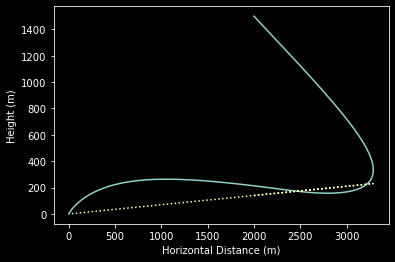

In [ ]:
tany_gs = np.tan(y_gs)
horizontal_distance = np.linalg.norm(np.transpose(x.value[1:3, :]) - rf[1:3], axis = 1)
plt.plot(horizontal_distance, x.value[0, :])
plt.plot(horizontal_distance, horizontal_distance * tany_gs, linestyle = 'dotted')
plt.xlabel("Horizontal Distance (m)")
plt.ylabel("Height (m)")

In [ ]:
plt.plot(T, np.linalg.norm(u.value, axis = 0) / T_max * m)
plt.xlabel("Time (s)")
plt.ylabel("Thrust (N)")
plt.plot(T, s.value / T_max * m)

TypeError: unsupported operand type(s) for *: 'float' and 'map'